<a href="https://colab.research.google.com/github/Raanank10/Detecting-Parkinson-s-Disease/blob/080821/Detecting_Parkinsons_Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecting Parkinsons Disease

In [152]:
pip install catboost

In [153]:
# General Tools
import numpy as np
import scipy as sp
import pandas as pd
import missingno as msno

# SK Learn
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score , confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# catboost
from catboost import CatBoostClassifier, CatBoostRegressor

# Trees Visualization
import pydot
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO

# Misc
import warnings
from sys import modules
from time import time
from platform import python_version
import re

# Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# IPython
from IPython.display import Image, display

# Confuguration
warnings.filterwarnings('ignore')
%matplotlib inline

# Load Data

In [154]:
url = 'https://raw.githubusercontent.com/Raanank10/Detecting-Parkinson-s-Disease/main/parkinsons.csv'

data = pd.read_csv(url)
data.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,0.02182,0.03130,0.02971,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,0.03134,0.04518,0.04368,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,0.02757,0.03858,0.03590,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,0.02924,0.04005,0.03772,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,0.03490,0.04825,0.04465,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [155]:
trainSize = 0.70
randState = 990

# EDA

In [156]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

## Data Cleaning

In [157]:
data.nunique()

name                195
MDVP:Fo(Hz)         195
MDVP:Fhi(Hz)        195
MDVP:Flo(Hz)        195
MDVP:Jitter(%)      173
MDVP:Jitter(Abs)     19
MDVP:RAP            155
MDVP:PPQ            165
Jitter:DDP          180
MDVP:Shimmer        188
MDVP:Shimmer(dB)    149
Shimmer:APQ3        184
Shimmer:APQ5        189
MDVP:APQ            189
Shimmer:DDA         189
NHR                 185
HNR                 195
status                2
RPDE                195
DFA                 195
spread1             195
spread2             194
D2                  195
PPE                 195
dtype: int64

In [158]:
unique_data = data.drop_duplicates(inplace=False)
unique_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

In [159]:
data.describe()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,154.228641,197.104918,116.324631,0.006220,0.000044,0.003306,0.003446,0.009920,0.029709,0.282251,0.015664,0.017878,0.024081,0.046993,0.024847,21.885974,0.753846,0.498536,0.718099,-5.684397,0.226510,2.381826,0.206552
std,41.390065,91.491548,43.521413,0.004848,0.000035,0.002968,0.002759,0.008903,0.018857,0.194877,0.010153,0.012024,0.016947,0.030459,0.040418,4.425764,0.431878,0.103942,0.055336,1.090208,0.083406,0.382799,0.090119
min,88.333000,102.145000,65.476000,0.001680,0.000007,0.000680,0.000920,0.002040,0.009540,0.085000,0.004550,0.005700,0.007190,0.013640,0.000650,8.441000,0.000000,0.256570,0.574282,-7.964984,0.006274,1.423287,0.044539
25%,117.572000,134.862500,84.291000,0.003460,0.000020,0.001660,0.001860,0.004985,0.016505,0.148500,0.008245,0.009580,0.013080,0.024735,0.005925,19.198000,1.000000,0.421306,0.674758,-6.450096,0.174351,2.099125,0.137451
50%,148.790000,175.829000,104.315000,0.004940,0.000030,0.002500,0.002690,0.007490,0.022970,0.221000,0.012790,0.013470,0.018260,0.038360,0.011660,22.085000,1.000000,0.495954,0.722254,-5.720868,0.218885,2.361532,0.194052
75%,182.769000,224.205500,140.018500,0.007365,0.000060,0.003835,0.003955,0.011505,0.037885,0.350000,0.020265,0.022380,0.029400,0.060795,0.025640,25.075500,1.000000,0.587562,0.761881,-5.046192,0.279234,2.636456,0.252980
max,260.105000,592.030000,239.170000,0.033160,0.000260,0.021440,0.019580,0.064330,0.119080,1.302000,0.056470,0.079400,0.137780,0.169420,0.314820,33.047000,1.000000,0.685151,0.825288,-2.434031,0.450493,3.671155,0.527367


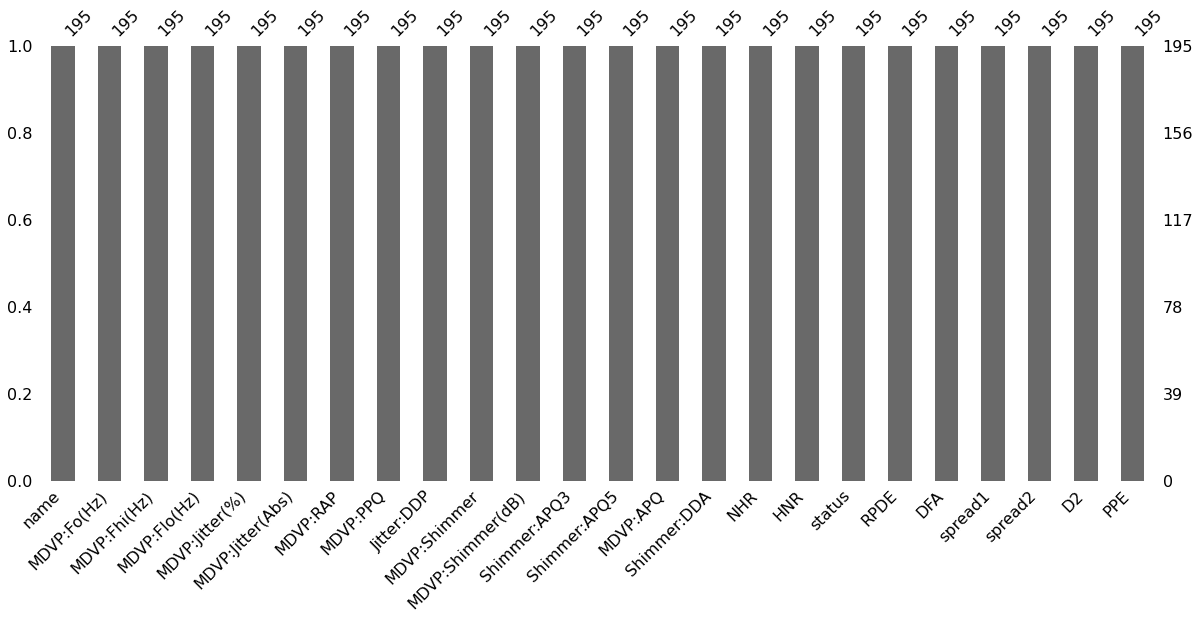

In [160]:
msno.bar(data, figsize=(20, 8))

## Preprocessing

In [161]:
data.corr()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
MDVP:Fo(Hz),1.000000,0.400985,0.596546,-0.118003,-0.382027,-0.076194,-0.112165,-0.076213,-0.098374,-0.073742,-0.094717,-0.070682,-0.077774,-0.094732,-0.021981,0.059144,-0.383535,-0.383894,-0.446013,-0.413738,-0.249450,0.177980,-0.372356
MDVP:Fhi(Hz),0.400985,1.000000,0.084951,0.102086,-0.029198,0.097177,0.091126,0.097150,0.002281,0.043465,-0.003743,-0.009997,0.004937,-0.003733,0.163766,-0.024893,-0.166136,-0.112404,-0.343097,-0.076658,-0.002954,0.176323,-0.069543
MDVP:Flo(Hz),0.596546,0.084951,1.000000,-0.139919,-0.277815,-0.100519,-0.095828,-0.100488,-0.144543,-0.119089,-0.150747,-0.101095,-0.107293,-0.150737,-0.108670,0.210851,-0.380200,-0.400143,-0.050406,-0.394857,-0.243829,-0.100629,-0.340071
MDVP:Jitter(%),-0.118003,0.102086,-0.139919,1.000000,0.935714,0.990276,0.974256,0.990276,0.769063,0.804289,0.746625,0.725561,0.758255,0.746635,0.906959,-0.728165,0.278220,0.360673,0.098572,0.693577,0.385123,0.433434,0.721543
MDVP:Jitter(Abs),-0.382027,-0.029198,-0.277815,0.935714,1.000000,0.922911,0.897778,0.922913,0.703322,0.716601,0.697153,0.648961,0.648793,0.697170,0.834972,-0.656810,0.338653,0.441839,0.175036,0.735779,0.388543,0.310694,0.748162
MDVP:RAP,-0.076194,0.097177,-0.100519,0.990276,0.922911,1.000000,0.957317,1.000000,0.759581,0.790652,0.744912,0.709927,0.737455,0.744919,0.919521,-0.721543,0.266668,0.342140,0.064083,0.648328,0.324407,0.426605,0.670999
MDVP:PPQ,-0.112165,0.091126,-0.095828,0.974256,0.897778,0.957317,1.000000,0.957319,0.797826,0.839239,0.763580,0.786780,0.804139,0.763592,0.844604,-0.731510,0.288698,0.333274,0.196301,0.716489,0.407605,0.412524,0.769647
Jitter:DDP,-0.076213,0.097150,-0.100488,0.990276,0.922913,1.000000,0.957319,1.000000,0.759555,0.790621,0.744894,0.709907,0.737439,0.744901,0.919548,-0.721494,0.266646,0.342079,0.064026,0.648328,0.324377,0.426556,0.671005
MDVP:Shimmer,-0.098374,0.002281,-0.144543,0.769063,0.703322,0.759581,0.797826,0.759555,1.000000,0.987258,0.987625,0.982835,0.950083,0.987626,0.722194,-0.835271,0.367430,0.447424,0.159954,0.654734,0.452025,0.507088,0.693771
MDVP:Shimmer(dB),-0.073742,0.043465,-0.119089,0.804289,0.716601,0.790652,0.839239,0.790621,0.987258,1.000000,0.963198,0.973751,0.960977,0.963202,0.744477,-0.827805,0.350697,0.410684,0.165157,0.652547,0.454314,0.512233,0.695058


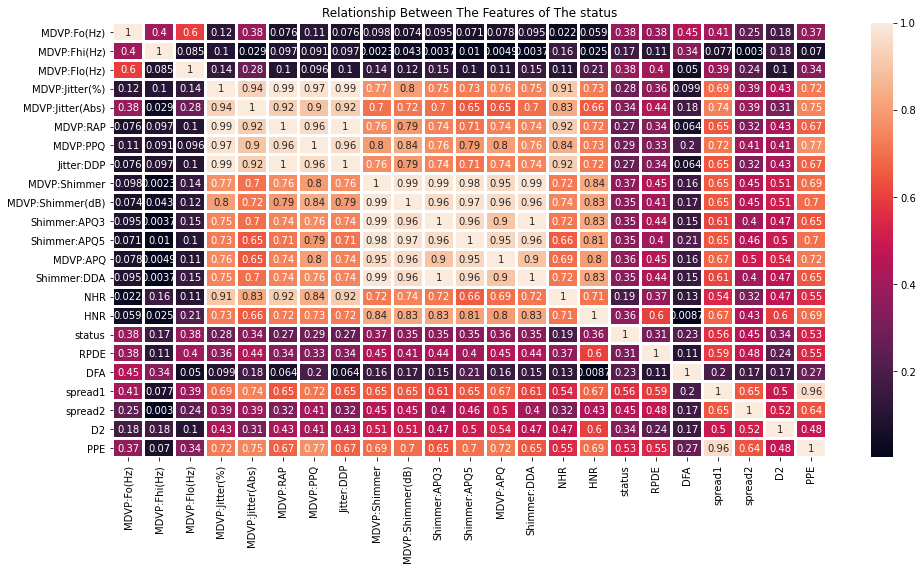

In [162]:
plt.figure(figsize=(16,8))
plt.title("Relationship Between The Features of The status")
sns.heatmap(data.corr().abs(), annot=True, linewidths = 2, linecolor = "white")

In [163]:
fig = px.histogram(data, x='spread1', title='Distribution of spread1', marginal='box',color='status' )
fig.update_layout(bargap=0.1)
fig.show()

In [164]:
fig = px.histogram(data, x='spread2', title='Distribution of spread2', marginal='box',color='status' )
fig.update_layout(bargap=0.1)
fig.show()

In [165]:
fig = px.histogram(data, x='PPE', title='Distribution of PPE', marginal='box',color='status' )
fig.update_layout(bargap=0.1)
fig.show()

In [166]:
data.status.value_counts()

1    147
0     48
Name: status, dtype: int64

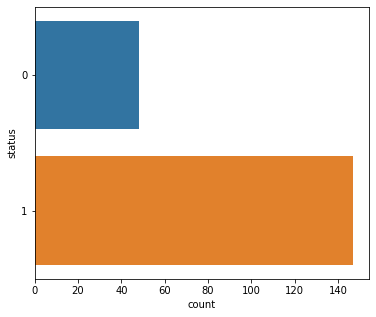

In [167]:
fig , ax = plt.subplots(figsize = (6,5))
ax = sns.countplot(y= 'status', data = data)

In [168]:
enc = OrdinalEncoder()

In [169]:
enc.fit(unique_data[['name']])

OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>)

In [170]:
data['name_as_number'] = enc.transform(data[['name']])
data = data.drop('name', axis=1)

# Spliting the Data

In [171]:
X = data.drop('status', axis=1)
y = data.status

# MinMaxScaler
X = MinMaxScaler().fit_transform(X)

X = pd.DataFrame(X)

X_train,X_test,y_train,y_test=train_test_split(X, y, train_size = trainSize, \
      random_state = randState, stratify = data.status)

In [172]:
print('train_df shape :',X_train.shape)
print('X_test shape :',X_test.shape)
print('X_train shape :',y_train.shape)
print('test_df shape :',y_test.shape)

train_df shape : (136, 23)
X_test shape : (59, 23)
X_train shape : (136,)
test_df shape : (59,)


# Different predictions models

# Model 1 Decision Tree unbalanced Data

In [21]:
t1 = time()
dt_model_1 = DecisionTreeClassifier().fit(X_train, y_train)
t2 = time()
print(f"DecisionTree unbalanced took {t2-t1:.2f} seconds")

DecisionTree unbalanced took 0.00 seconds


In [22]:
def visualize_tree(model, md=10, width=800):
    dot_data = StringIO()  
    export_graphviz(model, out_file=dot_data, feature_names=X_train.columns, max_depth=md, label='none')
    graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]  
    return Image(graph.create_png(), width=width) 

In [23]:
def print_dot_text(model, md=5):
    """The output of this function can be copied to http://www.webgraphviz.com/"""
    dot_data = StringIO()
    export_graphviz(model, out_file=dot_data, feature_names=X_train.columns, max_depth=md)
    dot_text = dot_data.getvalue()
    print(dot_text)

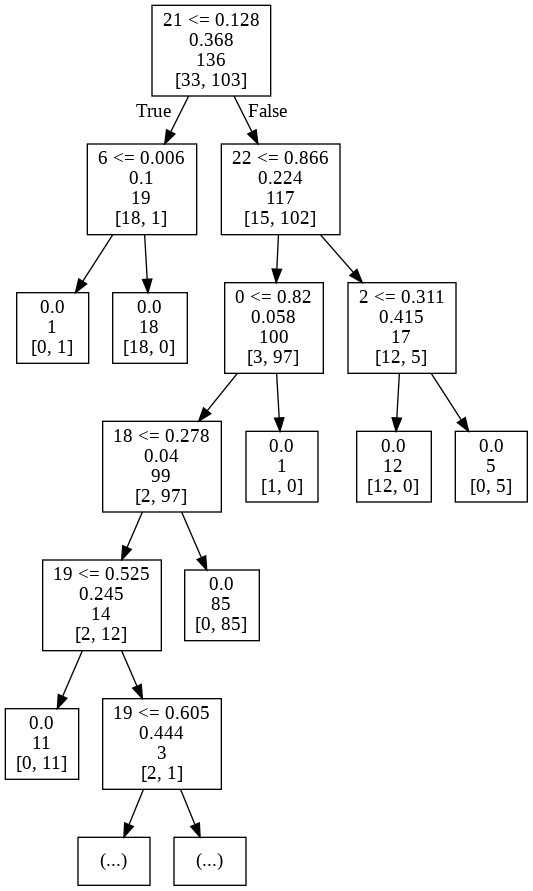

In [24]:
visualize_tree(dt_model_1, md=5, width=600)

In [25]:
pd.Series(dt_model_1.feature_importances_, index=X_train.columns).sort_values(ascending=False)

21    0.438863
22    0.265579
2     0.141218
19    0.068592
0     0.038027
6     0.037906
18    0.009815
17    0.000000
7     0.000000
1     0.000000
20    0.000000
3     0.000000
4     0.000000
5     0.000000
8     0.000000
16    0.000000
9     0.000000
10    0.000000
12    0.000000
13    0.000000
14    0.000000
15    0.000000
11    0.000000
dtype: float64

In [26]:
dt_model_1.tree_.max_depth

6

In [27]:
dt_model_1.feature_importances_

array([0.03802735, 0.        , 0.14121801, 0.        , 0.        ,
       0.        , 0.03790589, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.0098153 , 0.0685916 ,
       0.        , 0.4388633 , 0.26557856])

### Evaluate the model

In [28]:
X_test_pred = X_test.copy()

X_test_pred['y_pred'] = dt_model_1.predict(X_test)
X_test_pred['y_train'] = y_test
X_test_pred.sample(6)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,y_pred,y_train
126,0.289989,0.194113,0.090032,0.119441,0.130435,0.108863,0.125938,0.109006,0.167701,0.132293,0.198190,0.167571,0.117926,0.198164,0.055034,0.395716,0.855472,0.653223,0.438375,0.182097,0.177061,0.351131,0.649485,1,1
86,0.523304,0.204752,0.435081,0.048602,0.051383,0.045761,0.054662,0.045593,0.256071,0.198850,0.311633,0.250339,0.158128,0.311657,0.098227,0.304113,0.798318,0.549457,0.288932,0.741704,0.547623,0.207268,0.443299,1,1
84,0.515363,0.211101,0.056813,0.183926,0.130435,0.168593,0.175777,0.168566,0.350648,0.287592,0.428351,0.332700,0.213722,0.428361,0.172041,0.221572,0.699807,0.618726,0.483836,0.758182,0.745602,0.409214,0.432990,1,1
149,0.665411,0.946334,0.643557,0.463469,0.288538,0.409923,0.466774,0.409697,0.567464,0.614626,0.589368,0.501357,0.439620,0.589421,0.249037,0.266114,0.399124,0.802475,0.555508,0.576308,0.661483,0.467318,0.768041,1,1
135,0.128775,0.051984,0.230739,0.103558,0.130435,0.084778,0.119507,0.084604,0.289757,0.241578,0.341680,0.274355,0.198867,0.341764,0.078429,0.376575,0.925979,0.527497,0.475753,0.710843,0.537623,0.380632,0.695876,1,1
55,0.125323,0.049426,0.224308,0.224269,0.288538,0.158960,0.239550,0.158773,0.205861,0.182416,0.256934,0.192944,0.132859,0.257029,0.035490,0.500935,0.704688,0.946436,0.656567,0.485015,0.263058,0.621950,0.283505,1,1


In [29]:
X_test_pred['que'] = np.where((X_test_pred['y_pred'] == X_test_pred['y_train'])\
                     , 'yes', 'no')
X_test_pred['que'].value_counts()

yes    56
no      3
Name: que, dtype: int64

In [30]:
preds_1= dt_model_1.predict_proba(X_test)[:,1]

roc_auc_score(y_test,preds_1)

0.921969696969697

In [31]:
log_loss(y_test, preds_1)

1.756236074230381

In [32]:
accuracy_score(y_true=y_test, y_pred= preds_1)

0.9491525423728814

Text(0.5, 15.0, 'Predicted label')

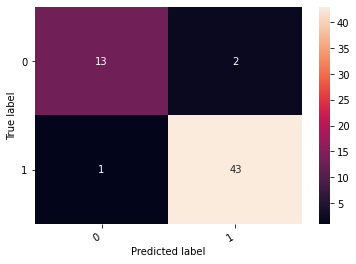

In [33]:
cm = confusion_matrix(y_true = y_test ,y_pred = X_test_pred.y_pred)
DT_model_cm = pd.DataFrame(cm, index=dt_model_1.classes_, columns=dt_model_1.classes_)
hmap = sns.heatmap(DT_model_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [34]:
print(classification_report(y_true=y_test,
                            y_pred=X_test_pred.y_pred))

              precision    recall  f1-score   support

           0       0.93      0.87      0.90        15
           1       0.96      0.98      0.97        44

    accuracy                           0.95        59
   macro avg       0.94      0.92      0.93        59
weighted avg       0.95      0.95      0.95        59



In [35]:
my_cv = StratifiedShuffleSplit(n_splits = 26, train_size = 0.75, random_state = randState) 

In [36]:
-cross_val_score(dt_model_1, X_train, y_train, cv=my_cv, scoring='accuracy') 

array([-0.94117647, -0.91176471, -0.97058824, -0.88235294, -0.91176471,
       -0.85294118, -0.88235294, -0.97058824, -0.79411765, -0.88235294,
       -0.94117647, -0.94117647, -0.91176471, -0.85294118, -0.94117647,
       -0.94117647, -0.79411765, -0.79411765, -0.91176471, -0.94117647,
       -0.97058824, -0.97058824, -0.94117647, -0.97058824, -0.97058824,
       -0.97058824])

In [37]:
dt_model_1_gs = DecisionTreeClassifier(min_samples_leaf=40, min_weight_fraction_leaf=0.01)

In [38]:
# %%timeit
-cross_val_score(dt_model_1_gs, X_train, y_train, cv=my_cv, scoring='neg_log_loss')

array([1.32086488, 0.41157628, 0.42889437, 0.44237675, 0.4524446 ,
       0.32066603, 0.64077185, 0.55267779, 0.40381055, 0.33748623,
       1.32086488, 1.32086488, 0.33748623, 0.39559348, 0.75436653,
       0.48432024, 0.55267779, 0.48117396, 0.44367814, 0.48737861,
       0.50320075, 1.30194413, 1.38534172, 0.47576359, 0.33748623,
       0.48877126])

In [39]:
my_param_grid = {'min_samples_leaf': [20, 40, 60],
                 'min_weight_fraction_leaf': [0.01, 0.02, 0.05],
                 'criterion': ['gini', 'entropy'], 
                 'min_impurity_decrease': [1e-5, 1e-6, 1e-7]}

In [40]:
dt_model_gs = GridSearchCV(estimator=dt_model_1_gs, param_grid=my_param_grid,\
                           cv=my_cv, scoring='neg_log_loss')

In [41]:
# %%timeit
dt_model_gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=26, random_state=990, test_size=None,
            train_size=0.75),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=40,
                                              min_samples_split=2,
                                              min_weigh...leaf=0.01,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='

In [42]:
print("Best parameters:", dt_model_gs.best_params_)

Best parameters: {'criterion': 'gini', 'min_impurity_decrease': 1e-05, 'min_samples_leaf': 60, 'min_weight_fraction_leaf': 0.01}


In [43]:
dt_model_gs_2 = dt_model_gs.best_estimator_

In [44]:
y_test_pred_gs_2 = pd.DataFrame(dt_model_gs_2.predict_proba(X_test),\
                           columns=dt_model_gs_2.classes_)

In [45]:
log_loss(y_true=y_test, y_pred=y_test_pred_gs_2)

0.5270947102736097

In [46]:
X_test_pred_2 = X_test.copy()

X_test_pred_2['y_pred'] = dt_model_gs_2.predict(X_test)
X_test_pred_2['y_train'] = y_test
X_test_pred_2.sample(6)

roc_auc_score(y_test,X_test_pred_2.y_pred)

0.5

In [47]:
log_loss(y_test, X_test_pred_2.y_pred)

8.781248133645986

In [48]:
accuracy_score(y_true=y_test, y_pred= X_test_pred_2.y_pred)

0.7457627118644068

Text(0.5, 15.0, 'Predicted label')

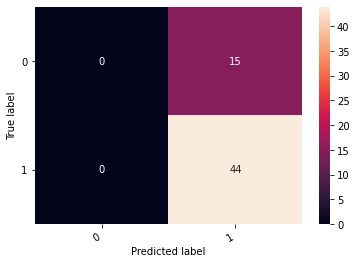

In [49]:
cm = confusion_matrix(y_true = y_test ,y_pred = X_test_pred_2.y_pred)
DT_model_cm = pd.DataFrame(cm, index=dt_model_1.classes_, columns=dt_model_1.classes_)
hmap = sns.heatmap(DT_model_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [50]:
print(classification_report(y_true=y_test,
                            y_pred=X_test_pred_2.y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.75      1.00      0.85        44

    accuracy                           0.75        59
   macro avg       0.37      0.50      0.43        59
weighted avg       0.56      0.75      0.64        59



# Model 2 Decision Tree balanced Data

In [51]:
t1 = time()
dt_model_bal = DecisionTreeClassifier(class_weight = 'balanced',min_samples_leaf=40,\
                                    min_weight_fraction_leaf=0.01).fit(X_train, y_train)
t2 = time()
print(f"DecisionTree balanced took {t2-t1:.2f} seconds")

DecisionTree balanced took 0.00 seconds


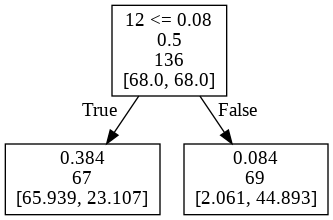

In [52]:
visualize_tree(dt_model_bal, md=5, width=600)

In [53]:
pd.Series(dt_model_bal.feature_importances_,\
          index=X_train.columns).sort_values(ascending=False)

12    1.0
22    0.0
10    0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
11    0.0
21    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
20    0.0
0     0.0
dtype: float64

### Evaluate the model

In [54]:
X_test_pred_bal = X_test.copy()

X_test_pred_bal['y_pred'] = dt_model_bal.predict(X_test)
X_test_pred_bal['y_train'] = y_test
X_test_pred_bal.sample(6)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,y_pred,y_train
96,0.412075,0.136293,0.456752,0.055273,0.051383,0.052987,0.049303,0.053139,0.221563,0.182416,0.260208,0.197286,0.160043,0.260175,0.025050,0.577989,0.256099,0.474678,0.279797,0.424009,0.467088,0.221963,0.494845,1,1
152,0.639120,0.267316,0.627552,0.808767,0.525692,0.722543,0.861200,0.722588,0.705678,0.766639,0.737481,0.676526,0.581898,0.737386,0.515644,0.040966,0.764369,0.717780,0.926645,0.787787,0.783293,0.849541,0.783505,1,1
31,0.645594,0.219168,0.728954,0.023189,0.011858,0.031792,0.024652,0.031787,0.005569,0.003287,0.009438,0.009634,0.003293,0.009565,0.003247,0.914370,0.410352,0.668402,0.051058,0.376042,0.302428,0.049628,0.159794,0,0
5,0.187568,0.059232,0.278139,0.254130,0.288538,0.190270,0.352626,0.190079,0.342067,0.304848,0.360747,0.401085,0.193277,0.360829,0.036827,0.525766,0.370978,0.999128,0.672961,0.659218,0.339999,0.648753,0.025773,1,1
113,0.709126,0.266514,0.689615,0.116264,0.090909,0.121869,0.100750,0.122010,0.066277,0.052588,0.078197,0.060651,0.044567,0.078251,0.017666,0.618955,0.430553,0.589516,0.361953,0.549299,0.474184,0.276015,0.582474,0,1
111,0.699683,0.241220,0.768846,0.140089,0.090909,0.144509,0.132369,0.144646,0.073672,0.057518,0.095724,0.066214,0.045026,0.095712,0.024350,0.567585,0.190225,0.550521,0.270036,0.400937,0.480032,0.190235,0.572165,0,1


In [55]:
preds_2_bal= dt_model_bal.predict_proba(X_test)[:,1]

roc_auc_score(y_test,preds_2_bal)

0.740909090909091

Text(0.5, 15.0, 'Predicted label')

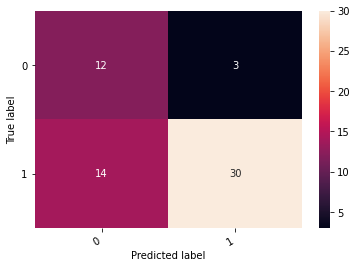

In [56]:
cm = confusion_matrix(y_true = y_test ,y_pred=X_test_pred_bal.y_pred)
DT2_model_cm = pd.DataFrame(cm, index= dt_model_bal.classes_, columns=dt_model_bal.classes_)
hmap = sns.heatmap(DT2_model_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [57]:
print(classification_report(y_true=y_test,
                            y_pred=X_test_pred_bal.y_pred))

              precision    recall  f1-score   support

           0       0.46      0.80      0.59        15
           1       0.91      0.68      0.78        44

    accuracy                           0.71        59
   macro avg       0.69      0.74      0.68        59
weighted avg       0.80      0.71      0.73        59



In [58]:
-cross_val_score(dt_model_bal, X_train, y_train, cv=my_cv, scoring='neg_log_loss')

array([1.39506196, 0.40883689, 0.58643845, 0.45660032, 0.53638376,
       0.37564051, 0.50016669, 0.62802865, 2.27330784, 0.41513757,
       1.39506196, 1.39506196, 0.41513757, 0.54599165, 0.7931835 ,
       0.72854999, 1.44016862, 0.50016669, 0.37564051, 1.39506196,
       0.53051875, 1.35185151, 1.53666221, 0.56988806, 0.41513757,
       0.49381777])

In [59]:
dt_model_bal.get_params()

{'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 40,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.01,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [60]:
my_param_grid = {'min_samples_leaf': [20, 40, 60],
                 'min_weight_fraction_leaf': [0.01, 0.02, 0.05],
                 'criterion': ['gini', 'entropy'], 
                 'min_impurity_decrease': [1e-5, 1e-6, 1e-7]}

In [61]:
dt_model_bal_gs = GridSearchCV(estimator=dt_model_bal,\
                           param_grid=my_param_grid, cv=my_cv, scoring='neg_log_loss')

In [62]:
dt_model_bal_gs.fit(X_train, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=26, random_state=990, test_size=None,
            train_size=0.75),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=40,
                                              min_samples_split=2,
                                              min...leaf=0.01,
                                              presort='deprecated',
                                              random_state=None,
                                    

In [63]:
print("Best parameters:", dt_model_bal_gs.best_params_)

Best parameters: {'criterion': 'gini', 'min_impurity_decrease': 1e-05, 'min_samples_leaf': 60, 'min_weight_fraction_leaf': 0.01}


In [64]:
dt_model_bal_gs_best = dt_model_bal_gs.best_estimator_

In [65]:
y_test_pred_bal = pd.DataFrame(dt_model_bal_gs_best.predict_proba(X_test),\
                              columns=dt_model_bal_gs_best.classes_)

In [66]:
log_loss(y_true=y_test, y_pred=y_test_pred_bal)

0.5629874386405868

## XGBoost

In [67]:
numSplits_XGB = 4
paramGrid_XGB = {'learning_rate': [ 0.15, 0.2, 0.25], \
             'n_estimators': [10, 50, 100], 'max_depth': [5,10,15]}

In [68]:
gsModel_XGB = GridSearchCV(estimator = xgb.XGBClassifier(scale_pos_weight=(48/147),\
      verbosity = 0, random_state = randState), param_grid = paramGrid_XGB, \
    scoring = 'precision', cv = numSplits_XGB) 

t1 = time()
gsModel_XGB.fit(X_train, y_train)
t2 = time()
print(f"XGBoost took {t2-t1:.2f} seconds")

XGBoost took 2.00 seconds


In [69]:
print("{:3} classifier:\n \
    \ttrain accuracy: {:.2f}\n \
    \ttest accuracy: {:.2f}"\
    .format('DT Gradient Boosting (XGBoost)', 
            accuracy_score(gsModel_XGB.predict(X_train), y_train), 
            accuracy_score(gsModel_XGB.predict(X_test), y_test)))

DT Gradient Boosting (XGBoost) classifier:
     	train accuracy: 0.96
     	test accuracy: 0.97


In [70]:
X_test_pred_XGB = X_test.copy()

X_test_pred_XGB['y_pred'] = gsModel_XGB.predict(X_test)
X_test_pred_XGB['y_train'] = y_test
X_test_pred_XGB.sample(6)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,y_pred,y_train
173,0.147766,0.029186,0.180991,0.057497,0.090909,0.049615,0.059486,0.049767,0.047289,0.039441,0.056433,0.045455,0.032851,0.056554,0.013146,0.735837,0.288587,0.766587,0.365485,0.418433,0.190961,0.279888,0.891753,0,0
137,0.144570,0.057411,0.202638,0.106099,0.130435,0.091040,0.117899,0.091186,0.394833,0.321282,0.470146,0.376798,0.261505,0.470214,0.115383,0.337560,0.860495,0.535186,0.598466,0.670464,0.555671,0.476045,0.706186,1,1
143,0.666418,0.264068,0.119498,0.064168,0.051383,0.058285,0.063773,0.058436,0.095216,0.078061,0.127504,0.082361,0.060265,0.127487,0.061909,0.416403,0.652227,0.232461,0.373590,0.466164,0.465979,0.299264,0.737113,1,1
110,0.654245,0.248705,0.139383,0.143901,0.090909,0.145954,0.131297,0.145770,0.121599,0.100247,0.141949,0.117910,0.086760,0.141995,0.020339,0.601398,0.418857,0.611862,0.489367,0.563191,0.501664,0.389333,0.567010,1,1
116,0.406853,0.694881,0.037261,0.097840,0.090909,0.070328,0.061629,0.070316,0.046011,0.051767,0.029083,0.024016,0.045409,0.029144,0.047395,0.728074,0.453189,0.316889,0.346007,0.601068,0.541629,0.260066,0.597938,1,1
5,0.187568,0.059232,0.278139,0.254130,0.288538,0.190270,0.352626,0.190079,0.342067,0.304848,0.360747,0.401085,0.193277,0.360829,0.036827,0.525766,0.370978,0.999128,0.672961,0.659218,0.339999,0.648753,0.025773,1,1


In [71]:
preds_XGB= gsModel_XGB.predict_proba(X_test)[:,1]

roc_auc_score(y_test,preds_XGB)

0.990909090909091

Text(0.5, 15.0, 'Predicted label')

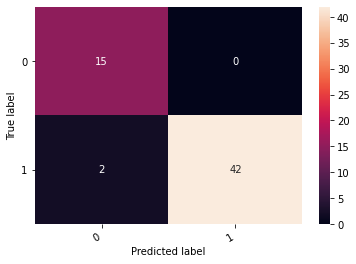

In [72]:
cm = confusion_matrix(y_true = y_test ,y_pred=X_test_pred_XGB.y_pred)
XGB_cm = pd.DataFrame(cm, index=gsModel_XGB.classes_, columns=gsModel_XGB.classes_)
hmap = sns.heatmap(XGB_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [73]:
print(classification_report(y_true=y_test,
                            y_pred=X_test_pred_XGB.y_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94        15
           1       1.00      0.95      0.98        44

    accuracy                           0.97        59
   macro avg       0.94      0.98      0.96        59
weighted avg       0.97      0.97      0.97        59



In [74]:
gsModel_XGB.best_params_

{'learning_rate': 0.15, 'max_depth': 5, 'n_estimators': 10}

# Model 3 Random Forest

In [75]:
rf_model_1 = RandomForestClassifier(class_weight = 'balanced')

rf_model_1.fit(X_train,y_train)
preds= rf_model_1.predict_proba(X_test)[:,1]

roc_auc_score(y_test,preds)

0.9613636363636364

In [76]:
pd.Series(rf_model_1.feature_importances_, index=X_train.columns).\
sort_values(ascending=False)

12    0.110395
21    0.110243
18    0.074580
22    0.073292
0     0.071716
11    0.059889
5     0.054608
1     0.042091
8     0.041521
9     0.037856
20    0.037106
19    0.035311
10    0.028520
14    0.027823
7     0.027581
2     0.027515
6     0.026078
13    0.024143
3     0.021699
17    0.018740
4     0.017603
16    0.016250
15    0.015439
dtype: float64

In [77]:
y_train_pred = pd.DataFrame(rf_model_1.predict_proba(X_train), 
                            columns=rf_model_1.classes_)
y_train_pred.head()

,0,1
0,0.00,1.00
1,0.92,0.08
2,0.00,1.00
3,0.00,1.00
4,0.87,0.13


### Evaluate the model

In [78]:
X_test_pred_rf = X_test.copy()

X_test_pred_rf['y_pred'] = rf_model_1.predict(X_test)
X_test_pred_rf['y_train'] = y_test
X_test_pred_rf.sample(6)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,y_pred,y_train
130,0.186037,0.053070,0.199967,0.102922,0.130435,0.096821,0.078242,0.096966,0.041811,0.032868,0.047766,0.033921,0.036373,0.047888,0.049177,0.630253,0.491366,0.596651,0.330809,0.444276,0.496665,0.259687,0.670103,1,1
96,0.412075,0.136293,0.456752,0.055273,0.051383,0.052987,0.049303,0.053139,0.221563,0.182416,0.260208,0.197286,0.160043,0.260175,0.025050,0.577989,0.256099,0.474678,0.279797,0.424009,0.467088,0.221963,0.494845,1,1
9,0.039139,0.036658,0.148249,0.115629,0.209486,0.096339,0.128617,0.096163,0.171992,0.139688,0.189908,0.156716,0.132093,0.190012,0.030461,0.545436,0.677741,0.893130,0.533923,0.719740,0.449094,0.469780,0.046392,1,1
140,0.477581,0.340184,0.080987,0.128018,0.090909,0.078998,0.094855,0.078985,0.211703,0.161052,0.242296,0.189145,0.161192,0.242329,0.077028,0.410428,0.981287,0.441324,0.572802,0.881266,0.685321,0.481927,0.721649,1,1
64,0.821251,0.306349,0.896289,0.011753,0.007905,0.022158,0.011254,0.022154,0.045919,0.036154,0.060478,0.052510,0.022743,0.060598,0.007480,0.730472,0.047319,0.395823,0.084745,0.113840,0.257909,0.060150,0.329897,0,0
154,0.179115,0.053680,0.134472,0.166455,0.209486,0.156551,0.111468,0.156526,0.157751,0.124076,0.198190,0.113297,0.099472,0.198164,0.144699,0.543892,0.921903,0.338841,0.673655,0.381382,0.457252,0.420266,0.793814,1,1


Text(0.5, 15.0, 'Predicted label')

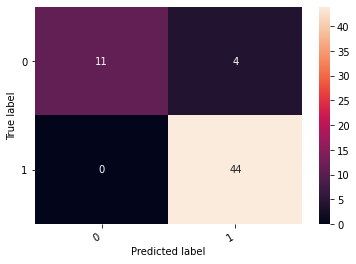

In [79]:
cm = confusion_matrix(y_true = y_test ,y_pred = X_test_pred_rf.y_pred)
RF_cm = pd.DataFrame(cm, index=rf_model_1.classes_, columns=rf_model_1.classes_)
hmap = sns.heatmap(RF_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [80]:
print(classification_report(y_true=y_test,
                            y_pred=X_test_pred_rf.y_pred))

              precision    recall  f1-score   support

           0       1.00      0.73      0.85        15
           1       0.92      1.00      0.96        44

    accuracy                           0.93        59
   macro avg       0.96      0.87      0.90        59
weighted avg       0.94      0.93      0.93        59



In [81]:
dt_model_bal_gs.best_params_

{'criterion': 'gini',
 'min_impurity_decrease': 1e-05,
 'min_samples_leaf': 60,
 'min_weight_fraction_leaf': 0.01}

In [82]:
rf_model_2 = RandomForestClassifier(**dt_model_bal_gs.best_params_)

In [83]:
my_param_grid = {'bootstrap': [True, False], 
                 'n_estimators': [25, 50], 
                 'oob_score': [True, False], 
                 'warm_start': [True, False]}

In [84]:
rf_model_gs = GridSearchCV(estimator=rf_model_2, param_grid=my_param_grid,\
                           scoring='accuracy', cv=my_cv)

In [85]:
t1 = time()
rf_model_gs.fit(X_train, y_train)
t2 = time()
print(f"It took {t2 - t1:.2f} seconds")

It took 18.29 seconds


In [86]:
print(rf_model_gs.score(X_train, y_train))
print(rf_model_gs.score(X_test, y_test))

0.7573529411764706
0.7457627118644068


In [87]:
bestModel = rf_model_gs.best_estimator_
bestModel.score(X_test, y_test)

0.7457627118644068

# Model 4 Logistic Regression

In [88]:
lr_model = LogisticRegression(class_weight='balanced', random_state = randState)
lr_model.get_params()

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 990,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [89]:
lr_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=990, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [90]:
X_test_pred_3 = X_test.copy()

X_test_pred_3['y_pred'] = lr_model.predict(X_test)
X_test_pred_3['y_train'] = y_test
X_test_pred_3.sample(6)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,y_pred,y_train
110,0.654245,0.248705,0.139383,0.143901,0.090909,0.145954,0.131297,0.145770,0.121599,0.100247,0.141949,0.117910,0.086760,0.141995,0.020339,0.601398,0.418857,0.611862,0.489367,0.563191,0.501664,0.389333,0.567010,1,1
170,0.912005,0.347153,1.000000,0.089898,0.051383,0.101638,0.077706,0.101621,0.086087,0.078882,0.121148,0.074763,0.041044,0.121261,0.031321,0.531862,0.621217,0.288981,0.119416,0.371020,0.298928,0.107038,0.876289,0,0
109,0.609511,0.217918,0.085328,0.189962,0.130435,0.184008,0.159164,0.184139,0.190798,0.156122,0.253467,0.168928,0.104526,0.253434,0.028074,0.548362,0.562283,0.662363,0.383277,0.613222,0.527372,0.292297,0.561856,1,1
171,0.140966,0.063748,0.231666,0.059403,0.090909,0.047206,0.052519,0.047359,0.036882,0.036154,0.040254,0.029308,0.032238,0.040313,0.011777,0.731326,0.365683,0.726748,0.296776,0.478618,0.342602,0.239914,0.881443,0,0
126,0.289989,0.194113,0.090032,0.119441,0.130435,0.108863,0.125938,0.109006,0.167701,0.132293,0.198190,0.167571,0.117926,0.198164,0.055034,0.395716,0.855472,0.653223,0.438375,0.182097,0.177061,0.351131,0.649485,1,1
0,0.184308,0.112592,0.054815,0.195680,0.249012,0.145472,0.247588,0.145288,0.312215,0.280197,0.332627,0.347354,0.172448,0.332584,0.068307,0.511745,0.369155,0.960148,0.569875,0.585765,0.390661,0.497310,0.000000,1,1


### Evaluate the model

Text(0.5, 15.0, 'Predicted label')

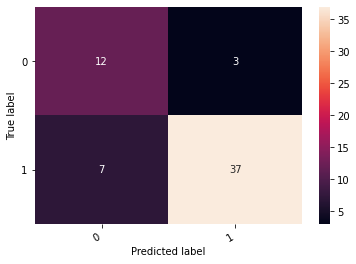

In [91]:
cm = confusion_matrix(y_true = y_test, y_pred=X_test_pred_3.y_pred)
LR_cm = pd.DataFrame(cm, index=lr_model.classes_, columns=lr_model.classes_)
hmap = sns.heatmap(LR_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [92]:
accuracy_score(y_true=y_test, y_pred=X_test_pred_3.y_pred)

0.8305084745762712

In [93]:
penalty = ['l1', 'l2']
C = np.logspace(0, 5, 10)
hyperparameters = dict(C=C, penalty=penalty)

In [94]:
clr = GridSearchCV(lr_model, hyperparameters, cv=20, verbose=2, scoring='accuracy')

In [95]:
best_model_clr = clr.fit(X_train, y_train)
print('Best Penalty:', best_model_clr.best_estimator_.get_params()['penalty'])
print('Best C:', round(best_model_clr.best_estimator_.get_params()['C'],2))

Fitting 20 folds for each of 20 candidates, totalling 400 fits
[CV] C=1.0, penalty=l1 ...............................................
[CV] ................................ C=1.0, penalty=l1, total=   0.0s
[CV] C=1.0, penalty=l1 ...............................................
[CV] ................................ C=1.0, penalty=l1, total=   0.0s
[CV] C=1.0, penalty=l1 ...............................................
[CV] ................................ C=1.0, penalty=l1, total=   0.0s
[CV] C=1.0, penalty=l1 ...............................................
[CV] ................................ C=1.0, penalty=l1, total=   0.0s
[CV] C=1.0, penalty=l1 ...............................................
[CV] ................................ C=1.0, penalty=l1, total=   0.0s
[CV] C=1.0, penalty=l1 ...............................................
[CV] ................................ C=1.0, penalty=l1, total=   0.0s
[CV] C=1.0, penalty=l1 ...............................................
[CV] .........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................................ C=1.0, penalty=l2, total=   0.0s
[CV] C=1.0, penalty=l2 ...............................................
[CV] ................................ C=1.0, penalty=l2, total=   0.0s
[CV] C=1.0, penalty=l2 ...............................................
[CV] ................................ C=1.0, penalty=l2, total=   0.0s
[CV] C=1.0, penalty=l2 ...............................................
[CV] ................................ C=1.0, penalty=l2, total=   0.0s
[CV] C=1.0, penalty=l2 ...............................................
[CV] ................................ C=1.0, penalty=l2, total=   0.0s
[CV] C=1.0, penalty=l2 ...............................................
[CV] ................................ C=1.0, penalty=l2, total=   0.0s
[CV] C=1.0, penalty=l2 ...............................................
[CV] ................................ C=1.0, penalty=l2, total=   0.0s
[CV] C=3.5938136638046276, penalty=l1 ................................
[CV] .

[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    5.6s finished


In [96]:
y_pred_gs = best_model_clr.predict(X_test)
cm_gs = confusion_matrix(y_true = y_test, y_pred=y_pred_gs)

In [97]:
pd.DataFrame(cm_gs, index=best_model_clr.classes_, columns=best_model_clr.classes_)

,0,1
0,11,4
1,1,43


In [98]:
y_pred_lr = lr_model.predict(X_test)
cm_gs = confusion_matrix(y_true = y_test, y_pred=y_pred_gs)

In [99]:
print(classification_report(y_true=y_test,
                            y_pred=y_pred_gs))

              precision    recall  f1-score   support

           0       0.92      0.73      0.81        15
           1       0.91      0.98      0.95        44

    accuracy                           0.92        59
   macro avg       0.92      0.86      0.88        59
weighted avg       0.92      0.92      0.91        59



In [100]:
accuracy_score(y_true=y_test, y_pred= y_pred_gs)

0.9152542372881356

In [101]:
Parkinsons_probs = pd.DataFrame(best_model_clr.predict_proba(X_train), \
                          columns=['P({})'.format(x) for x in best_model_clr.classes_], index=X_train.index)
X_train = X_train.join(Parkinsons_probs)
X_train.sample(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,P(0),P(1)
1,0.198327,0.094930,0.278323,0.254130,0.288538,0.191233,0.323687,0.191042,0.472887,0.444536,0.515986,0.535685,0.279424,0.516048,0.059331,0.432577,0.470830,0.977024,0.703277,0.741337,0.473145,0.671326,0.005155,4.557021e-11,1.000000e+00
167,1.000000,0.332270,0.989251,0.054320,0.011858,0.065992,0.050375,0.066142,0.098229,0.092030,0.140794,0.089552,0.049621,0.140775,0.026896,0.513777,0.430299,0.214242,0.080827,0.346991,0.203962,0.064304,0.860825,9.999998e-01,1.966819e-07
106,0.388567,0.125725,0.452934,0.000000,0.011858,0.000000,0.000000,0.000000,0.010042,0.009860,0.012904,0.008412,0.016004,0.013031,0.005347,0.865846,0.181065,0.412930,0.177869,0.401325,0.314359,0.128955,0.546392,7.831103e-01,2.168897e-01
147,0.554147,0.234073,0.551913,0.412325,0.288538,0.376204,0.389603,0.375983,0.465218,0.437962,0.464176,0.479104,0.431886,0.464180,0.190725,0.240836,0.516714,0.775647,0.666861,0.786689,0.764759,0.603830,0.757732,4.440892e-16,1.000000e+00
169,0.884708,0.291885,0.888384,0.110864,0.051383,0.119461,0.102358,0.119602,0.097133,0.104355,0.138867,0.084261,0.047860,0.138978,0.028647,0.511217,0.268950,0.286388,0.143788,0.150881,0.375087,0.116692,0.871134,9.995431e-01,4.569067e-04
90,0.455674,0.212015,0.072288,0.182338,0.130435,0.153661,0.193462,0.153636,0.519080,0.451109,0.615370,0.503664,0.336550,0.615291,0.275647,0.134236,0.925939,0.632985,0.624847,0.862093,0.842709,0.533136,0.463918,1.731948e-14,1.000000e+00
59,0.154356,0.345324,0.225707,0.222046,0.288538,0.146917,0.229368,0.147054,0.207322,0.217749,0.260015,0.190502,0.137836,0.259982,0.034313,0.537227,0.679930,0.968559,0.606735,0.484979,0.181685,0.563049,0.304124,6.748260e-01,3.251740e-01
61,0.786112,0.279335,0.191072,0.030496,0.011858,0.041426,0.031618,0.041259,0.086909,0.065735,0.107473,0.098507,0.047553,0.107523,0.007512,0.719215,0.446611,0.446133,0.121350,0.180312,0.399611,0.111874,0.314433,9.985569e-01,1.443060e-03
189,0.660416,0.327754,0.073416,0.167090,0.090909,0.165703,0.162915,0.165516,0.147891,0.139688,0.192411,0.137313,0.079562,0.192515,0.139288,0.444079,0.587775,0.436161,0.186317,0.345811,0.397292,0.141456,0.974227,9.140766e-01,8.592343e-02
139,0.161941,0.060394,0.255271,0.067662,0.090909,0.054432,0.075027,0.054262,0.189155,0.149548,0.203968,0.168521,0.157056,0.204070,0.056084,0.421036,0.859210,0.485116,0.379433,0.510550,0.454813,0.290882,0.716495,5.371207e-05,9.999463e-01


# Model 5 CATBoost 

In [173]:
cat_features = list(range(0, X.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]


In [174]:
categorical_features_indices = np.where(X.dtypes != np.float)[0]

In [194]:
cat_model = CatBoostClassifier(iterations=1000, depth=3, learning_rate=0.1, loss_function='Logloss')

In [195]:
t1 = time()

cat_model.fit(X_train, y_train,cat_features=categorical_features_indices,\
         eval_set=(X_test, y_test),use_best_model=True,plot=True)

print('CatBoost model is fitted: ' + str(cat_model.is_fitted()))
print('CatBoost model parameters:')
print(cat_model.get_params())

t2 = time()
print(f"CATBoost took {t2-t1:.2f} seconds")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5923793	test: 0.5857597	best: 0.5857597 (0)	total: 1.2ms	remaining: 1.2s
1:	learn: 0.5237895	test: 0.5396044	best: 0.5396044 (1)	total: 4.22ms	remaining: 2.11s
2:	learn: 0.4703300	test: 0.4884068	best: 0.4884068 (2)	total: 5.73ms	remaining: 1.9s
3:	learn: 0.4120279	test: 0.4338961	best: 0.4338961 (3)	total: 7.11ms	remaining: 1.77s
4:	learn: 0.3608858	test: 0.3848331	best: 0.3848331 (4)	total: 8.89ms	remaining: 1.77s
5:	learn: 0.3327599	test: 0.3625401	best: 0.3625401 (5)	total: 10.6ms	remaining: 1.75s
6:	learn: 0.3120940	test: 0.3359474	best: 0.3359474 (6)	total: 11.9ms	remaining: 1.69s
7:	learn: 0.2868013	test: 0.3122648	best: 0.3122648 (7)	total: 13.3ms	remaining: 1.64s
8:	learn: 0.2503817	test: 0.2723263	best: 0.2723263 (8)	total: 14.6ms	remaining: 1.6s
9:	learn: 0.2280310	test: 0.2624327	best: 0.2624327 (9)	total: 15.9ms	remaining: 1.57s
10:	learn: 0.2125772	test: 0.2520610	best: 0.2520610 (10)	total: 17.2ms	remaining: 1.54s
11:	learn: 0.1989862	test: 0.2316972	best: 0.

In [196]:
# predict the target on the train dataset
predict_train = cat_model.predict(X_train)
print('\nTarget on train data',predict_train) 

# Accuray Score on train dataset
accuracy_train = accuracy_score(y_train,predict_train)
print('\naccuracy_score on train dataset : ', accuracy_train)

# predict the target on the test dataset
predict_test = cat_model.predict(X_test)
print('\nTarget on test data',predict_test) 

# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_test,predict_test)
print('\naccuracy_score on test dataset : ', accuracy_test)



Target on train data [1 0 1 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0
 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 0 1 0 1 1 1 0 1 0 0 1 0 0 1
 0 1 1 0 1 0 0 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 0
 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1]

accuracy_score on train dataset :  1.0

Target on test data [1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0
 1 0 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 0 0 1 1 0]

accuracy_score on test dataset :  0.9830508474576272


Text(0.5, 15.0, 'Predicted label')

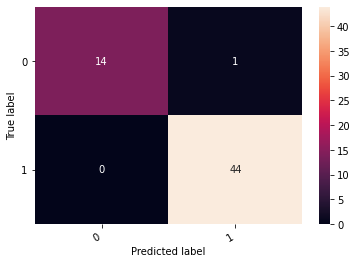

In [198]:
cm = confusion_matrix(y_true = y_test ,y_pred = predict_test)
XGB_cm = pd.DataFrame(cm, index=cat_model.classes_, columns=cat_model.classes_)
hmap = sns.heatmap(XGB_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')